In [2]:
import numpy as np
import os
from PIL import Image
import imageio
from tqdm.notebook import tqdm # forschritt balken
#os.listdir('C:/Users/Akademie/Desktop/data_externe/data_simpson_extern')
#Image.open('C:/Users/Akademie/Desktop/data_externe/data_simpson_extern/1.png')
im = imageio.imread('C:/Users/Akademie/Desktop/data_externe/data_simpson_extern/1.png')
files = os.listdir('C:/Users/Akademie/Desktop/data_externe/data_simpson_extern')
print(im.shape,len(files))

(200, 200, 3) 9877


## Einlesen der Bilder

In [3]:
def read_images(path):
    files = os.listdir(path)
    files = [file for file in files if file[-4:] == ".png"]
    images = []
    for file in tqdm(files):
        try:
            image = Image.open(os.path.join(path,file))

            #https://pillow.readthedocs.io/en/stable/reference/Image.html?highlight=resize
            image = image.resize((32,32),Image.LANCZOS)

            #https://pillow.readthedocs.io/en/stable/reference/Image.html?highlight=resize
            image = image.convert('RGB')
            image = np.asarray(image)

            images.append(image)
        except OSError:
            pass
    return images

simpsons = read_images('C:/Users/Akademie/Desktop/data_externe/data_simpson_extern')

<img scr ='C:/Users/Akademie/Desktop/data_externe/data_sympson_extern/1.png'/>

In [4]:
simpsons = np.asarray(simpsons)
simpsons.shape

(9877, 32, 32, 3)

In [5]:
from keras.datasets import cifar10

In [6]:
(X_train,y_train),(X_test,y_test) = cifar10.load_data()

In [7]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


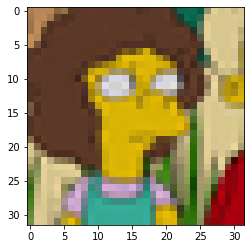

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.imshow(simpsons[11])
plt.show()


In [9]:
Not_simpsons = X_test
X = np.concatenate([simpsons,Not_simpsons])
Xpp = X # für VGG16 später
X.shape

(19877, 32, 32, 3)

In [10]:
Y = np.concatenate([np.ones(len(simpsons)),np.zeros(len(Not_simpsons))])
Y = Y.reshape(-1,1)
Y.shape

(19877, 1)

In [11]:
X = X.astype(np.float32)/255

## Model trainieren

In [12]:
#Eigine Neureunale Netzt
from keras.models import Sequential
from keras.layers import Conv2D, Dense , MaxPooling2D, Dropout, Flatten

model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(32,32,3)))
model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D())


model.add(Flatten())

model.add(Dense(1024,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

from keras.optimizers import Adam

model.compile(optimizer=Adam(lr=0.0001),loss='binary_crossentropy',metrics=['acc'])

model.fit(X,Y,epochs = 20,batch_size = 64) # Sehr langsame Berechnung (ca. 20 min)

Epoch 1/20
311/311 [==============================] - 36s 115ms/step - loss: 0.2551 - acc: 0.8928
Epoch 2/20
311/311 [==============================] - 35s 114ms/step - loss: 0.0341 - acc: 0.9892
Epoch 3/20
311/311 [==============================] - 36s 117ms/step - loss: 0.0302 - acc: 0.99110s - loss: 0.0302 - acc: 0.991
Epoch 4/20
311/311 [==============================] - 39s 125ms/step - loss: 0.0219 - acc: 0.9927
Epoch 5/20
311/311 [==============================] - 41s 131ms/step - loss: 0.0184 - acc: 0.9944
Epoch 6/20
311/311 [==============================] - 38s 122ms/step - loss: 0.0146 - acc: 0.9952
Epoch 7/20
311/311 [==============================] - 38s 124ms/step - loss: 0.0189 - acc: 0.9947
Epoch 8/20
311/311 [==============================] - 37s 119ms/step - loss: 0.0108 - acc: 0.9963
Epoch 9/20
311/311 [==============================] - 38s 122ms/step - loss: 0.0111 - acc: 0.9963
Epoch 10/20
311/311 [==============================] - 40s 130ms/step - loss: 0.0069 - a

In [13]:
model.save('Simpson_Model.h5')

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0

## Model mit VVG16 Netz

In [15]:
from keras.applications.vgg16 import VGG16, preprocess_input # preprocess_input fonktion teilt automatisch unter 255!!!!!

X = preprocess_input(Xpp)

In [16]:
vgg16_model = VGG16(include_top=False,input_shape=(32,32,3))
vgg16_model.trainable = False
#vgg16_model.summary()
X_after_vgg = vgg16_model.predict(X , verbose=1) # verbose --> meine forschritt Balken

622/622 [==============================] - 100s 161ms/step


In [17]:
X_after_vgg.shape

(19877, 1, 1, 512)

In [18]:
from keras.models import Sequential
from keras.layers import Dense,Flatten

model_vgg = Sequential()
#model_vgg.add(vgg16_model)

model_vgg.add(Flatten(input_shape=(1,1,512)))
model_vgg.add(Dense(1024,activation='relu'))
model_vgg.add(Dense(1,activation='sigmoid'))

model_vgg.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['acc'])

model_vgg.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1025      
Total params: 526,337
Trainable params: 526,337
Non-trainable params: 0
_________________________________________________________________


In [19]:
from sklearn.utils import shuffle

X_after_vgg,Y = shuffle(X_after_vgg,Y)

In [20]:
model_vgg.fit(X_after_vgg,Y,epochs=20,batch_size=32,validation_split=0.25) 
# ca  2 min berechnung und bessere geneugkeit
# validation_split

Epoch 1/20
466/466 [==============================] - 2s 5ms/step - loss: 0.3102 - acc: 0.9778 - val_loss: 0.1082 - val_acc: 0.9938
Epoch 2/20
466/466 [==============================] - 2s 5ms/step - loss: 0.0388 - acc: 0.9967 - val_loss: 0.0775 - val_acc: 0.9954
Epoch 3/20
466/466 [==============================] - 2s 5ms/step - loss: 0.0260 - acc: 0.9978 - val_loss: 0.0685 - val_acc: 0.9952
Epoch 4/20
466/466 [==============================] - 2s 5ms/step - loss: 0.0113 - acc: 0.9985 - val_loss: 0.0696 - val_acc: 0.9954
Epoch 5/20
466/466 [==============================] - 2s 5ms/step - loss: 0.0052 - acc: 0.9987 - val_loss: 0.0881 - val_acc: 0.9948
Epoch 6/20
466/466 [==============================] - 2s 5ms/step - loss: 0.0078 - acc: 0.9989 - val_loss: 0.1033 - val_acc: 0.9950
Epoch 7/20
466/466 [==============================] - 2s 5ms/step - loss: 0.0149 - acc: 0.9984 - val_loss: 0.1181 - val_acc: 0.9932
Epoch 8/20
466/466 [==============================] - 2s 5ms/step - loss: 0.

In [21]:
model_vgg.save('model_vgg_simpson.h5')
#model.save('model_simpson.h5')